<a href="https://colab.research.google.com/github/IrisFDTD/AI-UNIZAR-course/blob/main/recurrent_networks/ai_unizar_course_recurrent_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Licencia Creative Commons" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">*Introducción a la inteligencia artificial: redes neuronales avanzadas con Tensorflow-Keras*</span> por <span xmlns:cc="http://creativecommons.org/ns#" property="cc:attributionName">Sergio Gutiérrez Rodrigo (sergut@unizar.es)</span> se distribuye bajo una <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Licencia Creative Commons Atribución-NoComercial-CompartirIgual 4.0 Internacional</a>.

```
Sergio G Rodrigo
Departamento de Física Aplicada
Universidad de Zaragoza
Instituto de Nanociencia y Materiales de Aragón (INMA)
C/ Pedro Cerbuna, 12, 50009, Zaragoza, España
```






# **Advanced Neural Networks with TensorFlow-Keras**

---
# **Time Series Prediction with Recurrent Neural Networks (RNN)**
---


In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Auxiliary functions

In [2]:
def plot_history(history):
    train_loss = history.history['loss']
    epochs = range(1, len(train_loss) + 1)

    # Extract the validation loss values
    val_loss = history.history['val_loss']

    # Plot the training loss and validation loss vs. epoch
    plt.rcParams.update({'font.size': 14})
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    pass


def plot_time_series(x,y_true,model,model_name):
    # Create the plot
    j=np.random.randint(x.shape[0])

    n_steps=x.shape[1]
    print(n_steps)
    time=list(range(1, n_steps + 1))

    pred=model.predict(x[j].reshape(1, n_steps, 1))
    print(pred.shape)
    final_step=pred.shape[1]
    series=x[j]
    true=y_true[j][0:final_step]

    pred=np.squeeze(pred)
    true=np.squeeze(true)

    time_pred=np.arange(n_steps + 1,n_steps + 1+final_step)

    print("MSE=",tf.keras.losses.mean_squared_error([true],[pred]).numpy())

    plt.rcParams.update({'font.size': 14})
    plt.plot(time,series,label='data',marker='o',markersize=5)
    plt.plot(time_pred,true,'ro',label='target')
    plt.plot(time_pred,pred,'x',color='black',label=model_name)
    plt.xlabel(r'$t$ (time in a.u.)')
    plt.ylabel(r'$s(t)$')
    plt.grid(True)
    plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2,fontsize=12)
    # Show the plot
    plt.show()
    pass

# Generating time series: toy model

$s(t)$ signal as a function of time = two sinusoidal waves + noise
---

$s(t)=\dfrac{1}{2}\sin[(t-\phi_1)(10\omega_1+10)]+\dfrac{1}{5}\sin[(t-\phi_2)(20\omega_2+20)]+noise$

where:
+ $\omega_1, \omega_2, \phi_1, \phi_2 \in [0,1]$
+ $\Delta t=\dfrac{1}{n_{steps}}=\frac{1}{60}$
+ $noise \in [-0.05,0.05]$

In [3]:
def generate_time_series(batch_size, n_steps):
  '''
  Return 4 vectors of random numbers of length batch_size
  '''
  freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
  time = np.linspace(0, 1, n_steps)
  series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
  series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
  series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
  return series[..., np.newaxis].astype(np.float32) # data shape for RNN (samples,time steps,number of features)

In [4]:
# Generate time series: n_steps for training and n_target as targets
n_steps = 50
n_target = 10
N_series=1000
N_train=700
N_val=200
N_test=100

series = generate_time_series(N_series, n_steps + n_target)
print("Time series shape (batch_size,time steps,number of features)=",series.shape)

X_train, Y_train = series[:N_train, :n_steps], series[:N_train, -n_target:, 0]
X_val, Y_val = series[N_train:N_train+N_val, :n_steps], series[N_train:N_train+N_val, -n_target:, 0]
X_test, Y_test = series[N_series-N_test:, :n_steps], series[N_series-N_test:, -n_target:, 0]

Time series shape (batch_size,time steps,number of features)= (1000, 60, 1)


In [5]:
print(X_train.shape,Y_train.shape)
print(X_val.shape,Y_val.shape)
print(X_test.shape,Y_test.shape)

(700, 50, 1) (700, 10)
(200, 50, 1) (200, 10)
(100, 50, 1) (100, 10)


## Plot example

j= 46


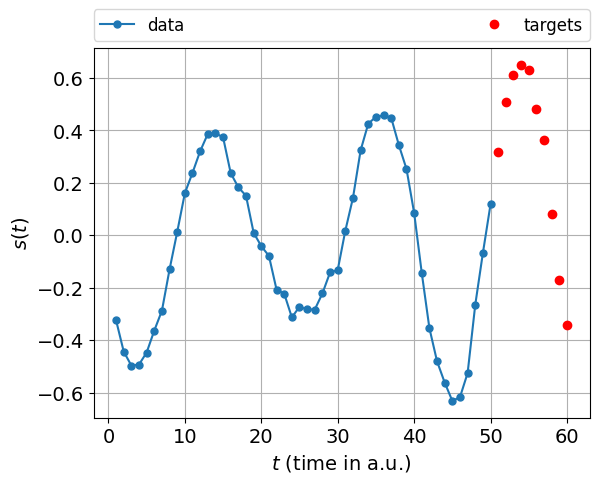

In [6]:
j=np.random.randint(X_test.shape[0])
print('j=',j)
plt.rcParams.update({'font.size': 14})
plt.plot(list(range(1, n_steps + 1)),X_test[j],label='data',marker='o',markersize=5)
plt.plot(list(range(n_steps + 1,n_steps + 11)),Y_test[j],'ro',label='targets')
plt.xlabel(r'$t$ (time in a.u.)')
plt.ylabel(r'$s(t)$')
plt.grid(True)
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2,fontsize=12)
# Show the plot
plt.show()

# **Predicting next time step of the time series**

# Baseline (naive prediction): predicting the next time step



In [7]:
#BASELINE1
#we predict the last value from each series
y_pred = X_test[:, -1]
print("y_pred baseline shape=",y_pred.shape)
print('MSE: ')
np.mean(tf.keras.losses.mean_squared_error(Y_test, y_pred))

y_pred baseline shape= (100, 1)
MSE: 


0.28575507

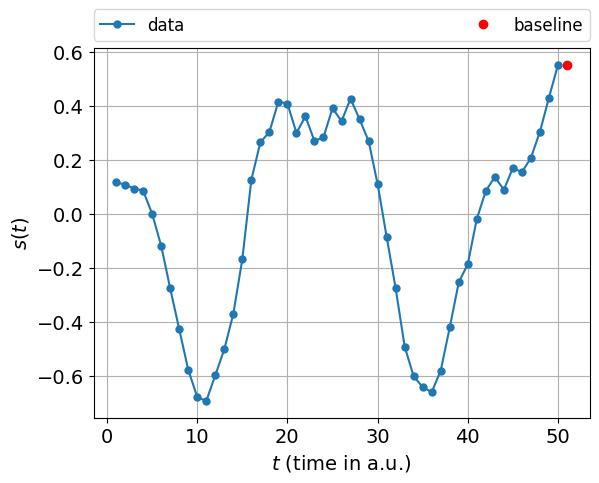

In [8]:
j=np.random.randint(X_test.shape[0])
plt.rcParams.update({'font.size': 14})
plt.plot(list(range(1, n_steps + 1)),X_test[j],label='data',marker='o',markersize=5)
plt.plot(list(range(n_steps + 1,n_steps + 2)),y_pred[j],'ro',label='baseline')
plt.xlabel(r'$t$ (time in a.u.)')
plt.ylabel(r'$s(t)$')
plt.grid(True)
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2,fontsize=12)
# Show the plot
plt.show()

# **Single Neuron**

## Dense Neural Network (DNN)

In [ ]:
model1 = tf.keras.models.Sequential([
tf.keras.layers.Flatten(input_shape=(50, 1)),
tf.keras.layers.Dense(1)
])

model1.summary()
model1.compile(loss='mse',
          optimizer='adam',
          metrics=['mae'])

history1=model1.fit(X_train, Y_train[:,0], epochs=40, validation_data=(X_val, Y_val[:,0]))


In [10]:
ypred=model1.predict(X_test)
np.mean(tf.keras.losses.mean_squared_error(Y_test, ypred))

4/4 [==============================] - 0s 5ms/step


0.22269556

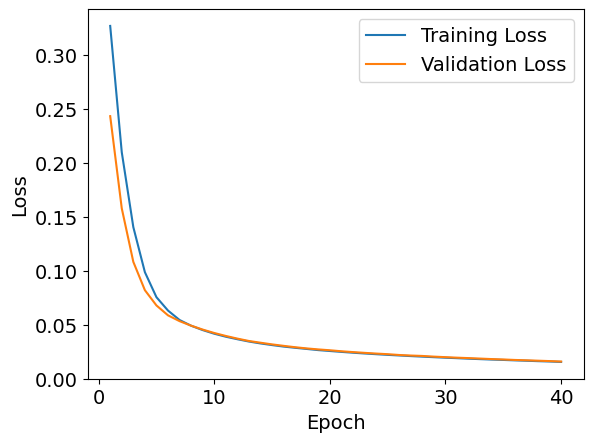

In [11]:
plot_history(history1)

50
1/1 [==============================] - 0s 32ms/step
(1, 1)
MSE= 0.0070356983


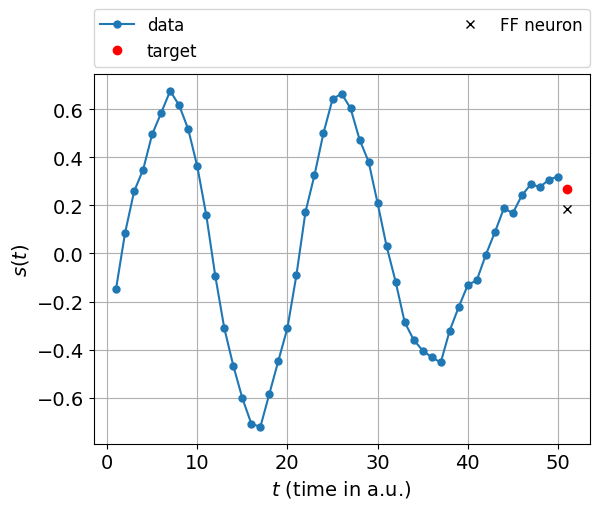

In [12]:
plot_time_series(X_test,Y_test,model=model1,model_name='FF neuron')

## Recurrent Neural Network (RNN)


Parameters per layer:
+ $W_x=n_{inputs} \times n_{neurons}$
+ $W_y=n_{neurons} \times n_{neurons}$
+ $b= n_{neurons}$

### Simple RNN

In [79]:
'''
By deafault, it will only return the last output, hyperbolic tangent activation
initial sate is set to 0.

We do not need to specify the length of the
input sequences (unlike with DNN), since a RNNs can
process any number of time steps (this is why we set the first input dimension to None)
'''
model2 = tf.keras.models.Sequential([
#tf.keras.layers.Flatten(input_shape=(50, 1)),        # Compare this line
tf.keras.layers.SimpleRNN(1, input_shape=(None, 1))]) # with this
model2.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_6 (SimpleRNN)    (None, 1)                 3         
                                                                 
Total params: 3 (12.00 Byte)
Trainable params: 3 (12.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model2.compile(loss='mse',
          optimizer='adam',
          metrics=['mae'])

history2=model2.fit(X_train, Y_train[:,0],
                    epochs=40,
                    validation_data=(X_val, Y_val[:,0]))

In [81]:
ypred=model2.predict(X_test)
np.mean(tf.keras.losses.mean_squared_error(Y_test[:,0], ypred))

4/4 [==============================] - 0s 6ms/step


0.33415124

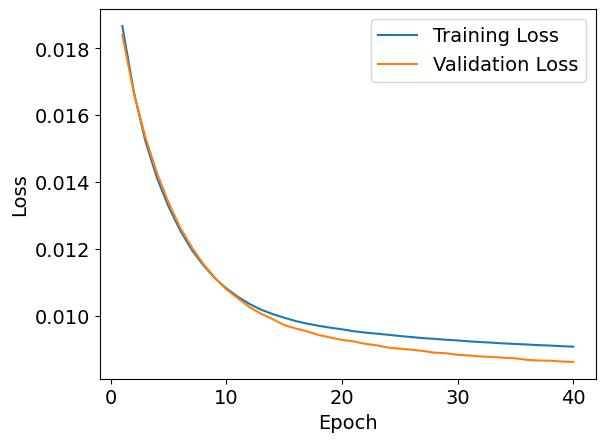

In [82]:
plot_history(history2)

50
1/1 [==============================] - 0s 20ms/step
(1, 1)
MSE= 0.004375546


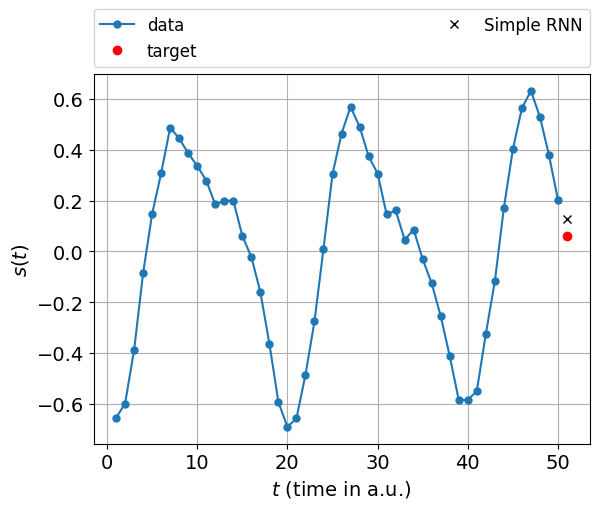

In [83]:
plot_time_series(X_test,Y_test,model=model2,model_name='Simple RNN')

### Custom Simple RNN code

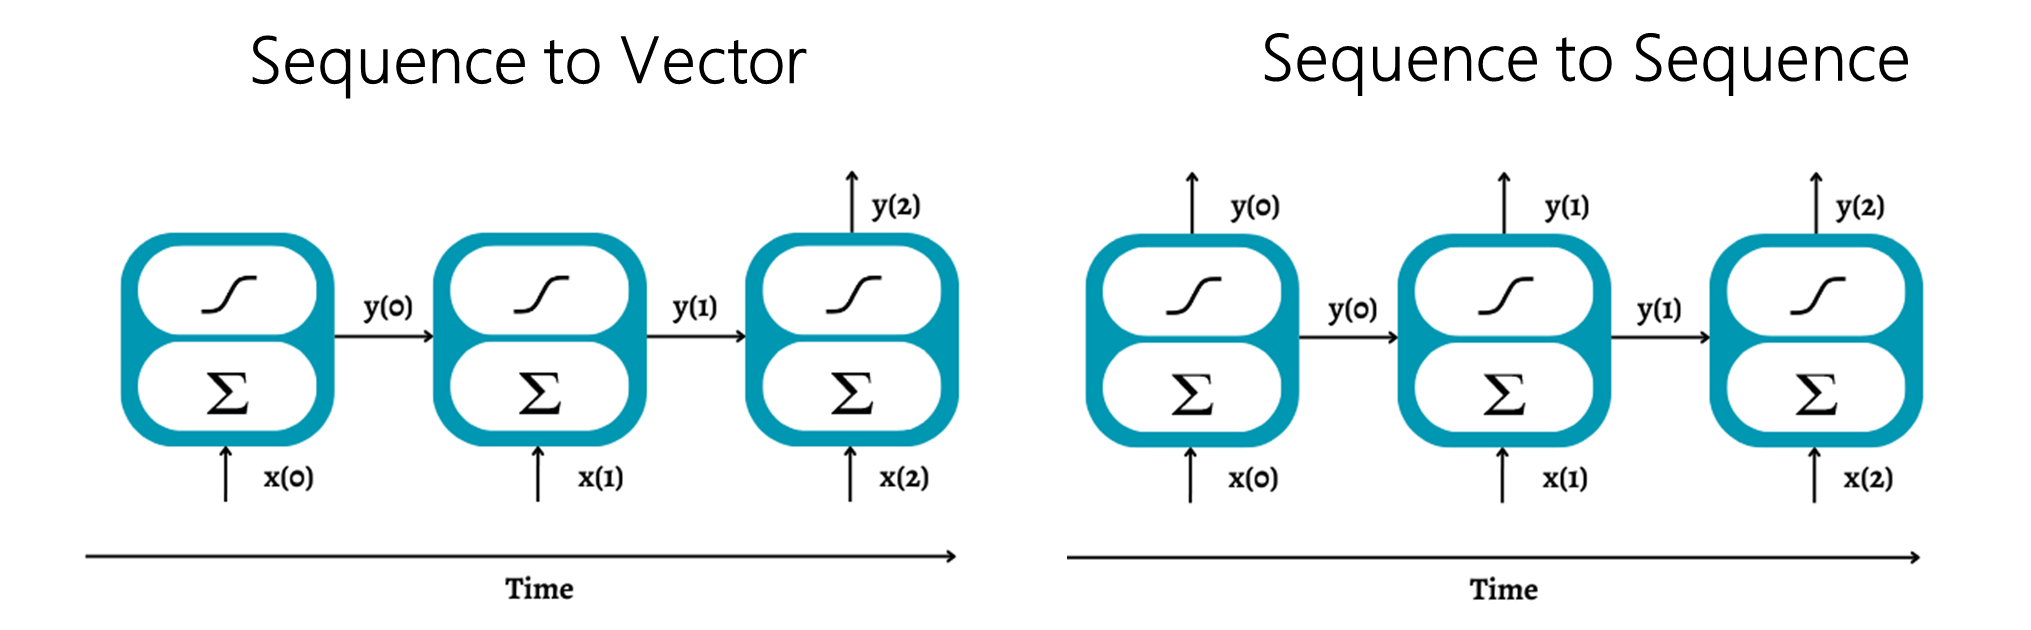

In [84]:
# Will take the weights from the SimpleRNN model
model2.weights

[<tf.Variable 'simple_rnn_6/simple_rnn_cell/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[1.7171596]], dtype=float32)>,
 <tf.Variable 'simple_rnn_6/simple_rnn_cell/recurrent_kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-0.7073703]], dtype=float32)>,
 <tf.Variable 'simple_rnn_6/simple_rnn_cell/bias:0' shape=(1,) dtype=float32, numpy=array([0.00284009], dtype=float32)>]

successive output length= 50
4/4 [==============================] - 0s 6ms/step
Custom SimpleRNN prediction shape= (50,)
Keras SimpleRNN shape= (1,)


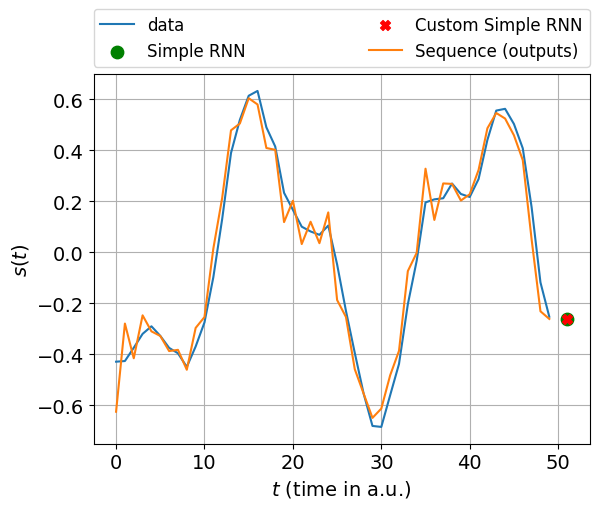

In [85]:
import numpy as np
# Take a random series from X_test
j=np.random.randint(X_test.shape[0])
inputs =X_test[j]

# Input_features and output_feauteres of the RNN cell
input_features = 1
output_features = 1

# Initial state of the RNN cell
state_t = np.zeros((output_features,))

# Weights and bias
W=model2.weights[0].numpy() # Regular kernel
U=model2.weights[1].numpy() # Recurrent Kernel
b=model2.weights[2].numpy() # bias

# List to add the successive outputs
successive_outputs = []

# Recurrent loop: for every time step (input_t) y produces the output_t
# that is appended into a list
# The state is updated in each iteration
for input_t in inputs:
  #print("input t=",input_t)
  output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
  #print("output t=",output_t)
  successive_outputs.append(output_t)
  state_t = output_t

# Get the final output sequence
print("successive output length=",len(successive_outputs))
final_output_sequence = np.concatenate(successive_outputs, axis=0)

# Predictions
pred_naive=final_output_sequence
pred_keras_SimpleRNN=model2.predict(X_test)[j]
print("Custom SimpleRNN prediction shape=",pred_naive.shape)
print("Keras SimpleRNN shape=",pred_keras_SimpleRNN.shape)

# Plot
plt.plot(inputs,label='data')
plt.scatter(51,pred_keras_SimpleRNN,label='Simple RNN',color='green',marker='o',s=80)
plt.scatter(51,pred_naive[-1],label='Custom Simple RNN',color='red',marker='X',s=50)
plt.plot(pred_naive,label='Sequence (outputs)')
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2,fontsize=12)
plt.xlabel(r'$t$ (time in a.u.)')
plt.ylabel(r'$s(t)$')
plt.grid(True)
plt.show()

### LSTM

In [93]:
'''
By deafault, it will only return the last output, hyperbolic tangent activation
initial sate is set to 0

We do not need to specify the length of the
input sequences (unlike in the previous model), since a recurrent neural network can
process any number of time steps (this is why we set the first input dimension to None)
'''
model3 = tf.keras.models.Sequential([
tf.keras.layers.LSTM(1, input_shape=(None, 1))])

model3.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 1)                 12        
                                                                 
Total params: 12 (48.00 Byte)
Trainable params: 12 (48.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model3.compile(loss='mse',
          optimizer='adam',
          metrics=['mae'])

history3=model3.fit(X_train, Y_train[:,0], epochs=40, validation_data=(X_val, Y_val[:,0]))

In [95]:
ypred=model3.predict(X_test)
np.mean(tf.keras.losses.mean_squared_error(Y_test, ypred))

4/4 [==============================] - 0s 5ms/step


0.21802774

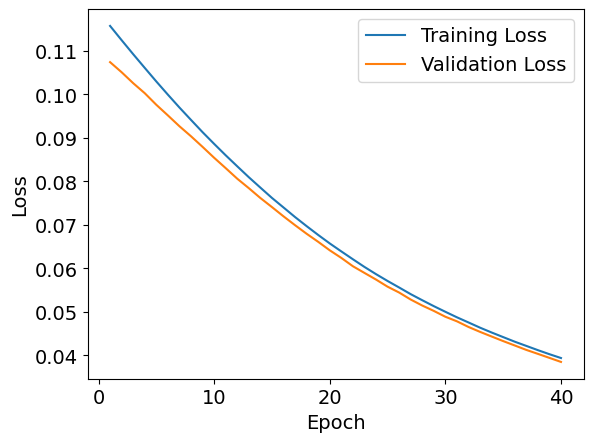

In [96]:
plot_history(history3)

50
1/1 [==============================] - 0s 19ms/step
(1, 1)
MSE= 0.09108801


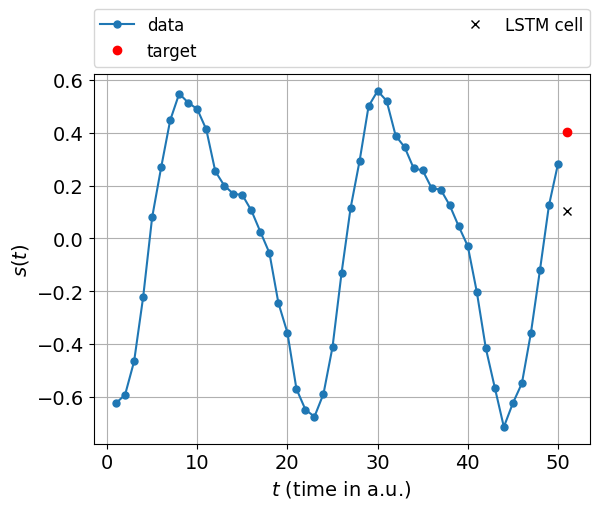

In [98]:
plot_time_series(X_test,Y_test,model=model3,model_name='LSTM cell')

### GRU

In [25]:
model4 = tf.keras.models.Sequential([
tf.keras.layers.GRU(1, input_shape=(None, 1))])

model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 1)                 12        
                                                                 
Total params: 12 (48.00 Byte)
Trainable params: 12 (48.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model4.compile(loss='mse',
          optimizer='adam',
          metrics=['mae'])

history4=model4.fit(X_train, Y_train[:,0], epochs=40, validation_data=(X_val, Y_val[:,0]))

In [27]:
ypred=model4.predict(X_test)
np.mean(tf.keras.losses.mean_squared_error(Y_test, ypred))

4/4 [==============================] - 0s 4ms/step


0.21895812

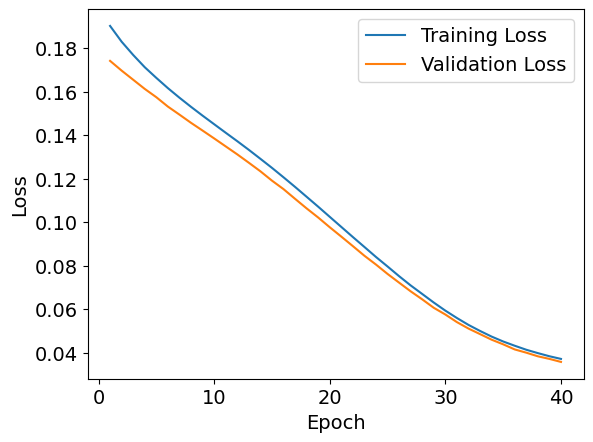

In [28]:
plot_history(history4)

50
1/1 [==============================] - 0s 20ms/step
(1, 1)
MSE= 0.10766899


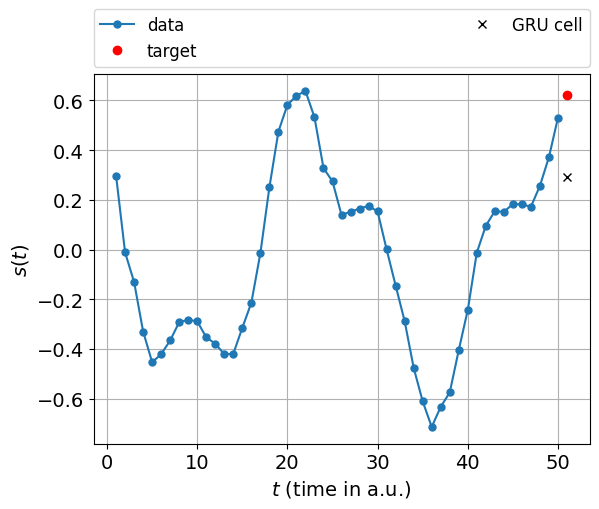

In [29]:
plot_time_series(X_test,Y_test,model=model4,model_name='GRU cell')

# **Deep Neural Networks**

### Dense Neural Network (DNN)

In [30]:
model5 = tf.keras.models.Sequential([
tf.keras.layers.Flatten(input_shape=[50, 1]),
tf.keras.layers.Dense(20),
tf.keras.layers.Dense(20),
tf.keras.layers.Dense(1)
])

model5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 20)                1020      
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1461 (5.71 KB)
Trainable params: 1461 (5.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model5.compile(loss='mse',
          optimizer='adam',
          metrics=['mae'])

history5=model5.fit(X_train, Y_train[:,0], epochs=40, validation_data=(X_val, Y_val[:,0]))

In [32]:
ypred=model5.predict(X_test)
np.mean(tf.keras.losses.mean_squared_error(Y_test, ypred))

4/4 [==============================] - 0s 4ms/step


0.25060266

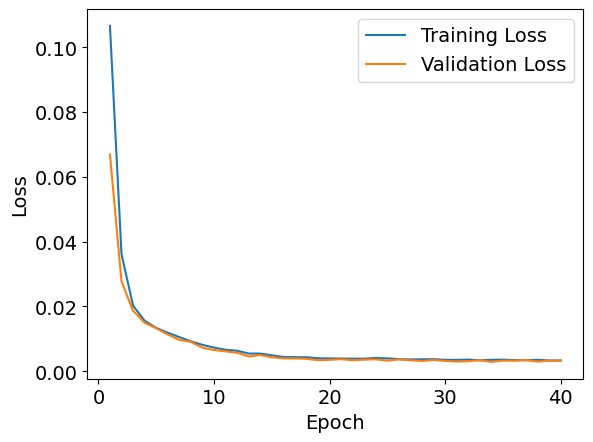

In [33]:
plot_history(history5)

50
1/1 [==============================] - 0s 27ms/step
(1, 1)
MSE= 2.6234029e-05


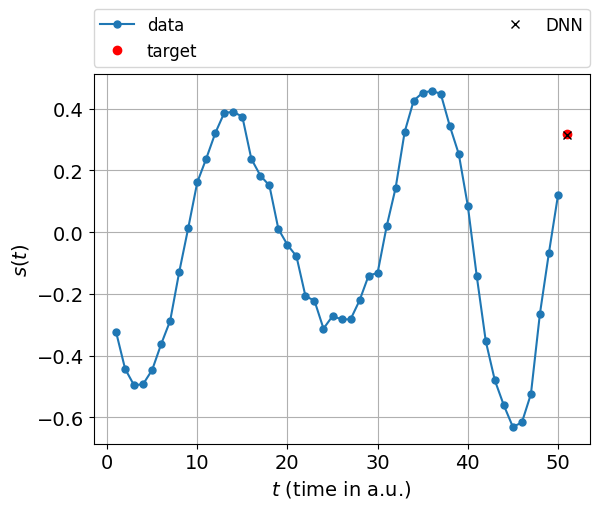

In [34]:
plot_time_series(X_test,Y_test,model=model5,model_name='DNN')

## Recurrent Neural Networks (RNN)

###Simple RNN

Parameters per layer:
+ $W_x=n_{inputs} \times n_{neurons}$
+ $W_y=n_{neurons} \times n_{neurons}$
+ $b= n_{neurons}$

In [35]:
# Set return_sequences=True for all recurrent layers except the last one
model6 = tf.keras.models.Sequential([
tf.keras.layers.SimpleRNN(20, return_sequences=True, input_shape=(None, 1)),
tf.keras.layers.SimpleRNN(20, return_sequences=True),
tf.keras.layers.SimpleRNN(1)
])

model6.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, None, 20)          440       
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, None, 20)          820       
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 1)                 22        
                                                                 
Total params: 1282 (5.01 KB)
Trainable params: 1282 (5.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [36]:
for layer in model6.layers:
  print("\n",layer.name)
  print("Layer input shape=",layer.input.shape)
  print("Layer output shape=",layer.output.shape)


 simple_rnn_1
Layer input shape= (None, None, 1)
Layer output shape= (None, None, 20)

 simple_rnn_2
Layer input shape= (None, None, 20)
Layer output shape= (None, None, 20)

 simple_rnn_3
Layer input shape= (None, None, 20)
Layer output shape= (None, 1)


In [ ]:
model6.compile(loss='mse',
          optimizer='adam',
          metrics=['mae'])

history6=model6.fit(X_train, Y_train[:,0], epochs=40, validation_data=(X_val, Y_val[:,0]))

In [38]:
ypred=model6.predict(X_test)
np.mean(tf.keras.losses.mean_squared_error(Y_test, ypred))

4/4 [==============================] - 0s 12ms/step


0.24264589

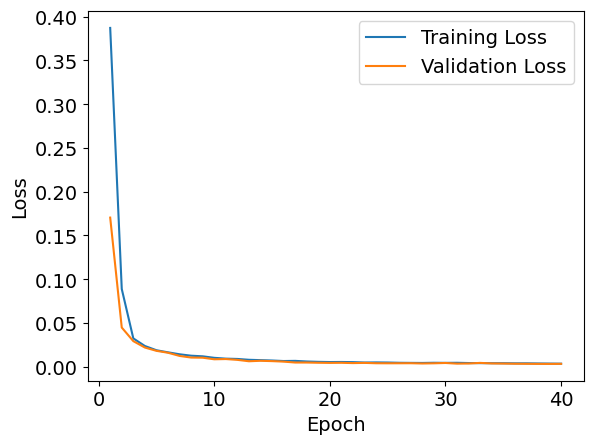

In [39]:
plot_history(history6)

50
1/1 [==============================] - 0s 30ms/step
(1, 1)
MSE= 4.165477e-05


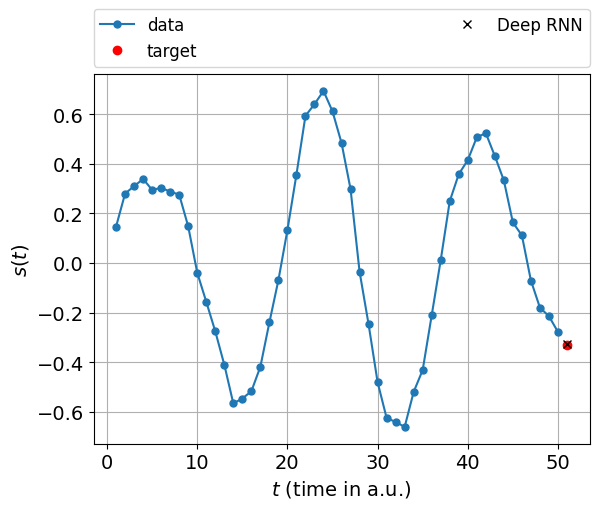

In [99]:
plot_time_series(X_test,Y_test,model=model6,model_name='Deep RNN')

In [41]:
model7 = tf.keras.models.Sequential([
tf.keras.layers.SimpleRNN(20, return_sequences=True, input_shape=(None, 1)),
tf.keras.layers.SimpleRNN(20),
tf.keras.layers.Dense(1)
])

model7.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, None, 20)          440       
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 20)                820       
                                                                 
 dense_4 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1281 (5.00 KB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model7.compile(loss='mse',
          optimizer='adam',
          metrics=['mae'])

history7=model7.fit(X_train, Y_train[:,0], epochs=40, validation_data=(X_val, Y_val[:,0]))

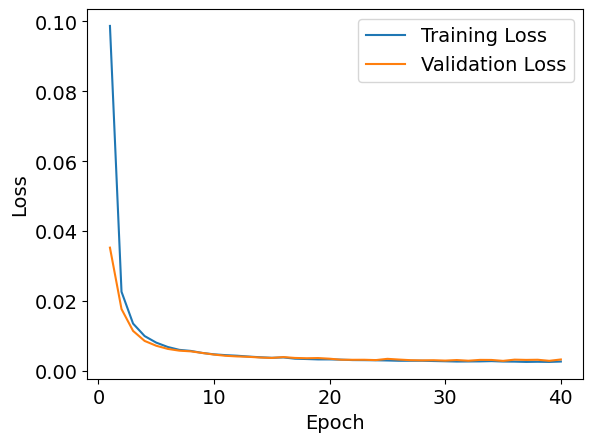

In [43]:
plot_history(history7)

50
1/1 [==============================] - 0s 222ms/step
(1, 1)
MSE= 0.00022320163


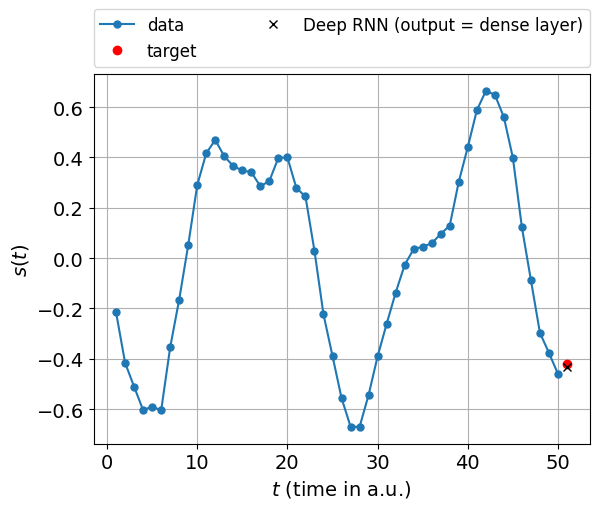

In [44]:
plot_time_series(X_test,Y_test,model=model7,model_name='Deep RNN (output = dense layer)')

### LSTM

In [45]:
model8 = tf.keras.models.Sequential([
tf.keras.layers.LSTM(20, return_sequences=True, input_shape=(None, 1)),
tf.keras.layers.LSTM(20),
tf.keras.layers.Dense(1)
])

model8.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, None, 20)          1760      
                                                                 
 lstm_2 (LSTM)               (None, 20)                3280      
                                                                 
 dense_5 (Dense)             (None, 1)                 21        
                                                                 
Total params: 5061 (19.77 KB)
Trainable params: 5061 (19.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model8.compile(loss='mse',
          optimizer='adam',
          metrics=['mae'])

history8=model8.fit(X_train, Y_train[:,0], epochs=40, validation_data=(X_val, Y_val[:,0]))

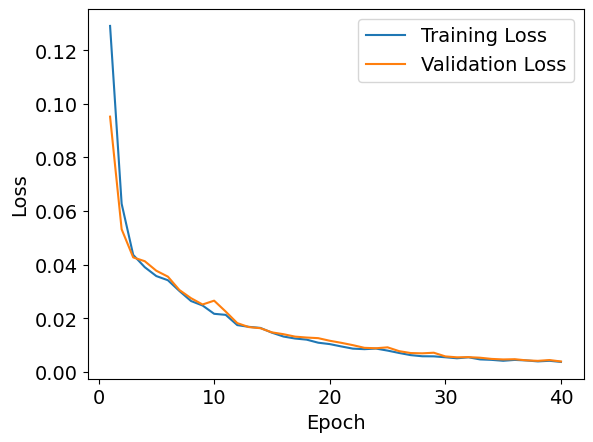

In [47]:
plot_history(history8)

50
1/1 [==============================] - 1s 639ms/step
(1, 1)
MSE= 0.00040063128


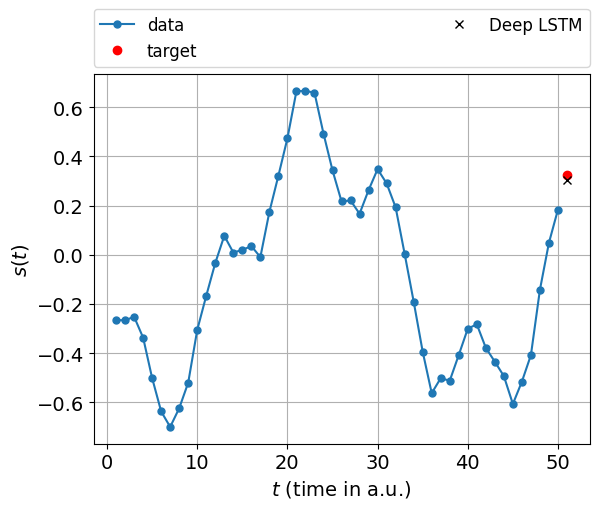

In [48]:
plot_time_series(X_test,Y_test,model=model8,model_name='Deep LSTM')



### GRU

In [49]:
model9 = tf.keras.models.Sequential([
tf.keras.layers.GRU(20, return_sequences=True, input_shape=(None, 1)),
tf.keras.layers.GRU(20),
tf.keras.layers.Dense(1)
])

model9.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, None, 20)          1380      
                                                                 
 gru_2 (GRU)                 (None, 20)                2520      
                                                                 
 dense_6 (Dense)             (None, 1)                 21        
                                                                 
Total params: 3921 (15.32 KB)
Trainable params: 3921 (15.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model9.compile(loss='mse',
          optimizer='adam',
          metrics=['mae'])

history9=model9.fit(X_train, Y_train[:,0], epochs=40, validation_data=(X_val, Y_val[:,0]))

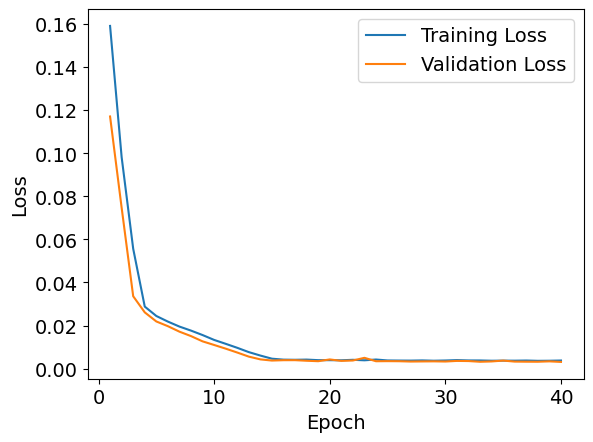

In [51]:
plot_history(history9)

50


1/1 [==============================] - 1s 877ms/step
(1, 1)
MSE= 0.006874666


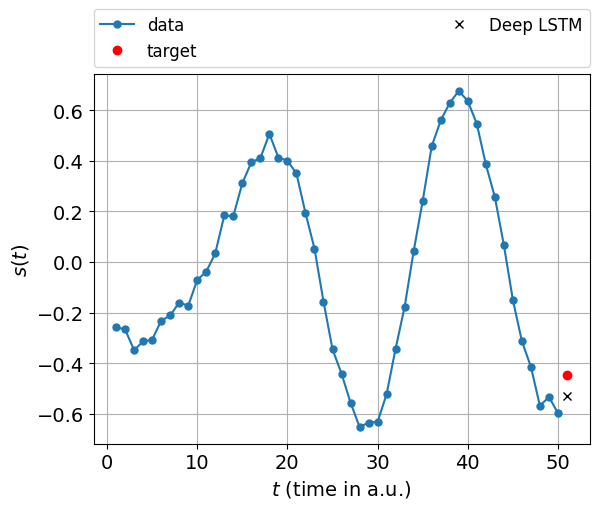

In [52]:
plot_time_series(X_test,Y_test,model=model9,model_name='Deep LSTM')

# **Forecasting several time steps from a pre-trained RNN**

Options:
1.   **Iterative method**: Forecast the next step, add it to the timeseriries, and repeat
2.   **Sequence to vector**: predict the last timesteps (targets).
3.   **Sequence to sequence**: give all steps at once.

## Forecasting the next step iteratively


In [53]:
model= model9 #Choose one of the previos already trained models

In [54]:
# Prediction
n_pred=n_target
j = np.random.randint(0, len(Y_test))

sequence=X_test[j].reshape(1,X_train.shape[1], 1)
for i in range (0,n_pred):
  pred=model.predict(sequence[:,i:,:]) #predict next timestep with previous 1000 steps
  sequence=np.concatenate((sequence, pred.reshape(1, 1, 1)), axis=1) #add it to the sequence
prediction=sequence[0,n_steps:,:]
print(prediction)

1/1 [==============================] - 0s 37ms/step
[[0.36145338]
 [0.47347888]
 [0.55823916]
 [0.60899806]
 [0.62437075]
 [0.60630304]
 [0.559511  ]
 [0.490372  ]
 [0.40549538]
 [0.31043303]]


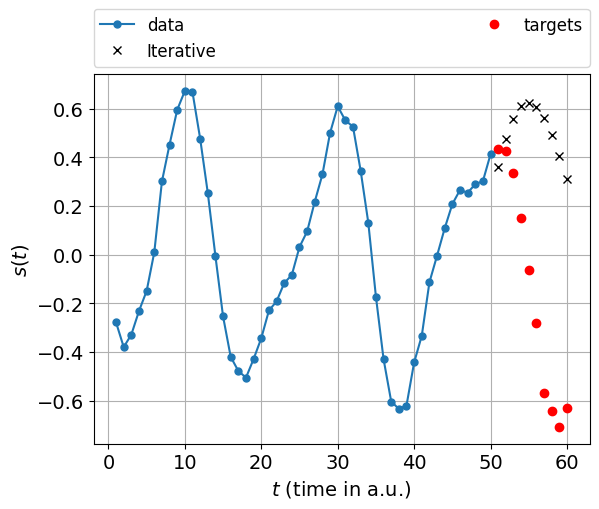

In [55]:
# Create the plot
j=np.random.randint(X_test.shape[0])
plt.rcParams.update({'font.size': 14})
plt.plot(list(range(1, n_steps + 1)),X_test[j],label='data',marker='o',markersize=5)
plt.plot(list(range(n_steps + 1,n_steps + 11)),prediction,'x',color='black',label='Iterative')
plt.plot(list(range(n_steps + 1,n_steps + 11)),Y_test[j],'ro',label='targets')
plt.xlabel(r'$t$ (time in a.u.)')
plt.ylabel(r'$s(t)$')
plt.grid(True)
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2,fontsize=12)
# Show the plot
plt.show()

## LSTM Sequence-to-Vector

In [56]:
model10 = tf.keras.models.Sequential([
tf.keras.layers.LSTM(20, return_sequences=True, input_shape=(None, 1)),
tf.keras.layers.LSTM(20),
tf.keras.layers.Dense(10)
])
model10.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, None, 20)          1760      
                                                                 
 lstm_4 (LSTM)               (None, 20)                3280      
                                                                 
 dense_7 (Dense)             (None, 10)                210       
                                                                 
Total params: 5250 (20.51 KB)
Trainable params: 5250 (20.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model10.compile(loss='mse',
          optimizer='adam',
          metrics='mae')

history10=model10.fit(X_train, Y_train, epochs=40, validation_data=(X_val, Y_val))

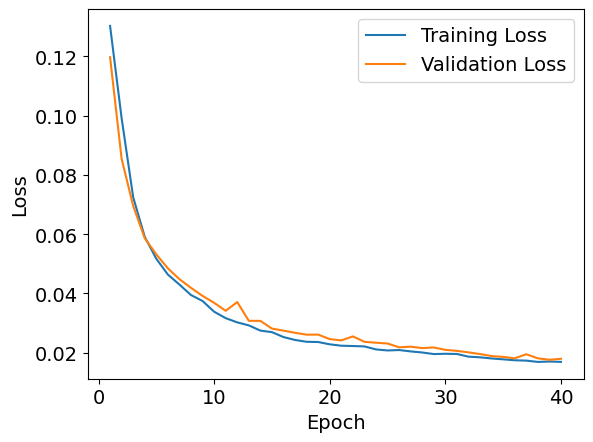

In [58]:
plot_history(history10)

50
1/1 [==============================] - 1s 1s/step
(1, 10)
MSE= [0.02392923]


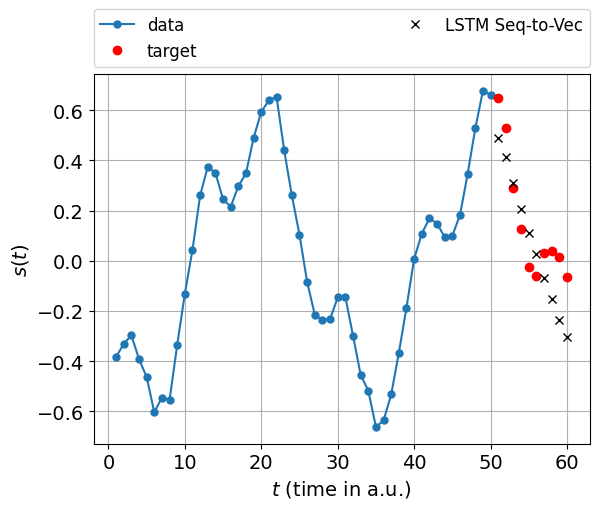

In [59]:
plot_time_series(X_test,Y_test,model=model10,model_name='LSTM Seq-to-Vec')

##LSTM Sequence-to-Sequence

### Generating data

In [60]:
# Every target will contain n_steps vectors of dimension 10, each one shifted by 10 steps.
n_steps = 50
target_len=10

Y = np.empty((N_series, n_steps, target_len)) # each target is a sequence of 10D vectors

for step_ahead in range(1, target_len + 1):
  Y[:, :, step_ahead - 1] = series[:, step_ahead:step_ahead + n_steps, 0]

Y_train_s2s = Y[:N_train]
Y_val_s2s = Y[N_train:N_train+N_val]
Y_test_s2s = Y[N_train+N_val:]

x_train shape= (700, 50, 1)
y_train shape= (700, 50, 10)


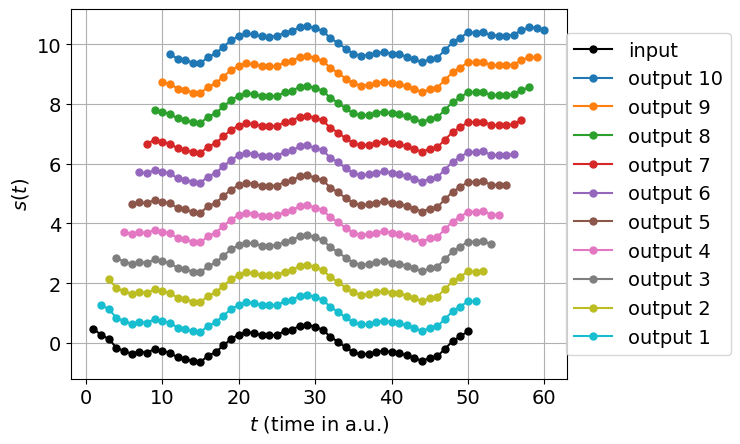

In [61]:
print("x_train shape=",X_train.shape)
print("y_train shape=",Y_train_s2s.shape)

# Create the plot
j=np.random.randint(X_test.shape[0])
plt.rcParams.update({'font.size': 14})
plt.plot(list(range(1, n_steps + 1)),X_test[j],color='black',label='input',markersize=5,marker='o')
for step_ahead in range(target_len ,0,-1):
  plt.plot(list(range(1+step_ahead, step_ahead+n_steps+1)),Y_test_s2s[j,:,step_ahead-1]+step_ahead,markersize=5,marker='o',label="output "+str(step_ahead))
plt.xlabel(r'$t$ (time in a.u.)')
plt.ylabel(r'$s(t)$')
plt.legend(loc='center right', bbox_to_anchor=(1.35, 0.5))
plt.grid(True)
#plt.legend()

# Show the plot
plt.show()

### The LSTM network


In [62]:
model11 = tf.keras.models.Sequential([
tf.keras.layers.LSTM(20, return_sequences=True, input_shape=(None, 1)),
tf.keras.layers.LSTM(20, return_sequences=True),
tf.keras.layers.Dense(10)
])

model11.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, None, 20)          1760      
                                                                 
 lstm_6 (LSTM)               (None, None, 20)          3280      
                                                                 
 dense_8 (Dense)             (None, None, 10)          210       
                                                                 
Total params: 5250 (20.51 KB)
Trainable params: 5250 (20.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [63]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model11.compile(loss="mse", optimizer=optimizer, metrics=['mae'])

In [ ]:
history11=model11.fit(X_train, Y_train_s2s, epochs=40, validation_data=(X_val, Y_val_s2s))

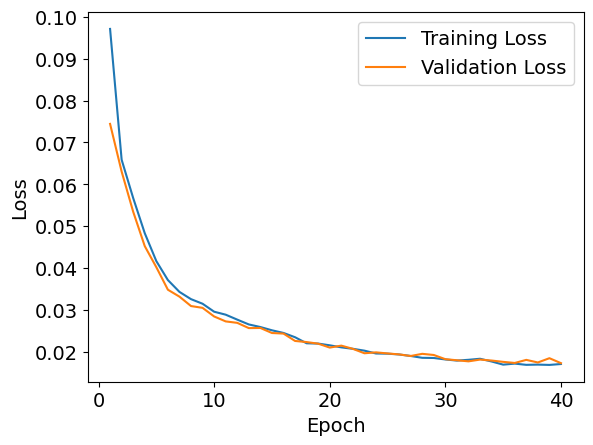

In [65]:
plot_history(history11)

1/1 [==============================] - 1s 656ms/step
(100, 50, 1)
(100, 50, 10)
(50, 10)
(1, 50, 10)
(50, 10)


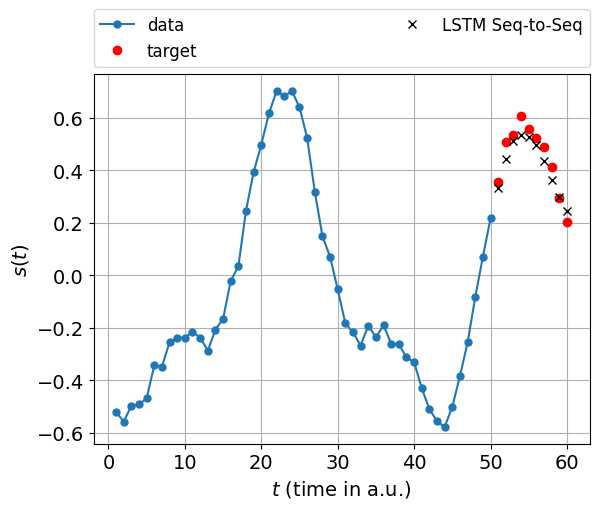

In [66]:
# Create the plot
# Y_test = samples x time_steps x target_points
# Each Y_test[j] = time_steps x target_points
# Note that Y_test[j,:,i] is the function shifted i+1 steps ahead
# Y_test[j][-1] are the last target_points values of all the shifted functions

target_len=10
j=np.random.randint(X_test.shape[0])
pred=model11.predict(X_test[j].reshape(1, 50, 1))
print(X_test.shape)
print(Y_test_s2s.shape)
print(Y_test_s2s[j].shape)
print(pred.shape)
print(pred[0].shape)

# Plot
plt.rcParams.update({'font.size': 14})
plt.plot(list(range(1, n_steps + 1)),X_test[j],label='data',marker='o',markersize=5)
plt.plot(list(range(n_steps + 1,n_steps + target_len+1)),Y_test_s2s[j][-1],'ro',label='target')
plt.plot(list(range(n_steps + 1,n_steps + target_len+1)),pred[0][-1],'x',color='black',label='LSTM Seq-to-Seq')
plt.xlabel(r'$t$ (time in a.u.)')
plt.ylabel(r'$s(t)$')
plt.grid(True)
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2,fontsize=12)
# Show the plot
plt.show()
